In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from gmphd import mtt_phd
from utils import *

In [2]:
# Measurement parameters
dim = 2
dt = 1.0
num_steps = 20

birth_prob = 0.2
death_prob = 0.005

det_prob = 0.9
clutter_rate = 3

pos_bounds = (-30, 30)
vel_bounds = (-1, 1)

area = (-100, 100)

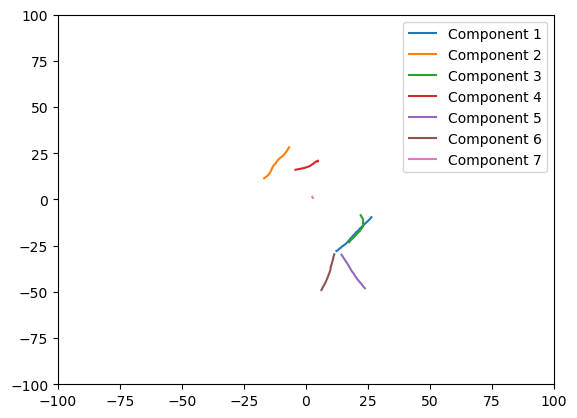

In [11]:
# generate ground truth data
F = create_state_matrix(dt, dim)
Q = np.identity(F.shape[0]) * 0.01

truths = simulate_motion(F, Q, num_steps=num_steps, birth_prob=birth_prob, death_prob=death_prob, pos_bounds=pos_bounds, vel_bounds=vel_bounds)
for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    plt.plot(*pos[:,:2].T, label=f'Component {i + 1}')
    plt.xlim(*area)
    plt.ylim(*area)
plt.legend()

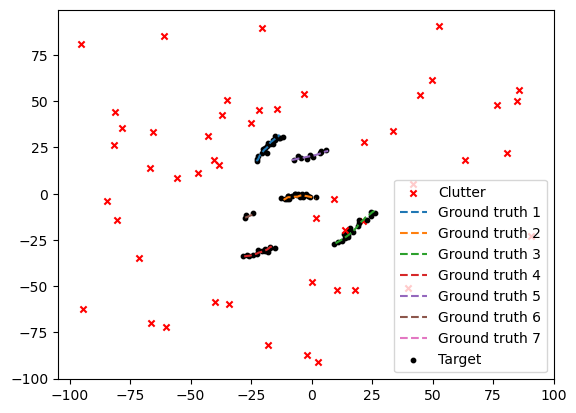

In [4]:
# generate measurements
H = create_measurement_matrix(dim)
R = np.identity(H.shape[0]) * 0.75

all_measurements = simulate_measurement(truths, H, R, num_steps=num_steps, det_prob=det_prob, clutter_rate=clutter_rate, area=area)

component_ids = sorted({i for measurements in all_measurements.values() for i, _ in measurements if i is not None})

for measurements in all_measurements.values():
    for i, measurement in measurements:
        if i is None:
            plt.scatter(measurement[0], measurement[1], c='red', marker='x', label='Clutter', s=20)
        else:
            plt.scatter(measurement[0], measurement[1], color='black', label=f'Target', s=10)
    
for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    # print(pos)
    plt.plot(*pos[:,:2].T, label=f'Ground truth {i + 1}', linestyle='dashed')

# ignore duplicates
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
order = np.argsort(list(unique.keys()))
plt.legend([list(unique.values())[i] for i in order], [list(unique.keys())[i] for i in order])

In [5]:
print("F")
print(F)
print("Q")
print(Q)
print("H")
print(H)
print("R")
print(R)

F
[[1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Q
[[0.01 0.   0.   0.  ]
 [0.   0.01 0.   0.  ]
 [0.   0.   0.01 0.  ]
 [0.   0.   0.   0.01]]
H
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]]
R
[[0.75 0.  ]
 [0.   0.75]]


In [6]:
# get initial truths
init_truths = []
for states in truths.values():
    if states[0] is not None:
        init_truths.append(states[0])
    
init_truths = np.array(init_truths)

num_components = len(init_truths)

# assume each component has the same weight
component_weight = 1.0

# the variance of pos and vel
pos_var = 10
vel_var = 5

# each component assumed to start at a random (x, y) ~ U([-100, 100] x [-100, 100])
start_bounds = (-50, 50)

w = [component_weight] * num_components
m = init_truths.copy()
m = np.array(m)
P = np.array([np.diag([pos_var, pos_var, vel_var, vel_var])**2 for _ in range(num_components)])

In [7]:
print("Initial weights:")
print(w)
print("Initial means:")
print(m)
print("Initial covariances:")
print(P)

Initial weights:
[1.0, 1.0, 1.0]
Initial means:
[[-22.81917571  17.70262063   0.55306627   0.76116492]
 [-11.52146069  -3.37004087   0.54706755   0.3597516 ]
 [  9.90995257 -26.82591714   0.80252983   0.76966018]]
Initial covariances:
[[[100   0   0   0]
  [  0 100   0   0]
  [  0   0  25   0]
  [  0   0   0  25]]

 [[100   0   0   0]
  [  0 100   0   0]
  [  0   0  25   0]
  [  0   0   0  25]]

 [[100   0   0   0]
  [  0 100   0   0]
  [  0   0  25   0]
  [  0   0   0  25]]]


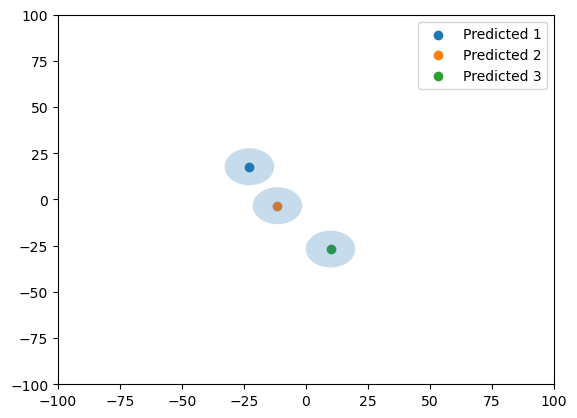

In [8]:
fig, ax = plt.subplots()
for i in range(len(w)):
    pos = m[i][:2]
    cov = P[i][:2, :2]
    eigvals, eigvecs = np.linalg.eig(cov)
    a = eigvals.argsort()[::-1]
    eigvals = eigvals[a]
    unc = patches.Ellipse(pos, 2 * np.sqrt(eigvals[0]), 2 * np.sqrt(eigvals[1]), angle=0, alpha=0.25)
    ax.scatter(pos[0], pos[1], marker='o', label=f'Predicted {i + 1}')
    ax.add_patch(unc)
    ax.set_xlim(*area)
    ax.set_ylim(*area)
plt.legend()

In [13]:
# initialize the filter
filter = mtt_phd(
    weights=w,
    position=m,
    p_cov=P,
    num_components=num_components,
    measurement=all_measurements,
    state_transition_matrix=F,
    process_noise_matrix=Q,
    measurement_matrix=H,
    measurement_noise=R,
    num_steps=len(all_measurements),
    detection_probability=det_prob,
    clutter_intensity=clutter_rate/np.prod(np.diff(np.vstack([area, area]))),
    merging_threshold = 5.0,
    truncation_threshold = 1e-8, # make sure squared
    threshold_weight= 0.8, # 0.60799
    new_birth_weight=0.25, # 0.25
)

history = filter.full_PHD_filter_run()

Prev pos: [  9.27262368 -27.17977522], New pos: [ 10.0735448  -26.41269624]
Prev pos: [-12.41346352  -2.51275837], New pos: [-11.86508694  -2.12501319]
Prev pos: [-22.81917571  17.70262063], New pos: [-22.26610943  18.46378555]
Prev pos: [-83.9139839   -3.91056604], New pos: [-83.36091762  -3.14940112]
Prev pos: [-12.21746155  -2.6394427 ], New pos: [-11.81239383  -2.25894506]
Prev pos: [  9.64905921 -27.14967729], New pos: [ 10.62043594 -26.40663221]
Prev pos: [-22.22070173  18.01664807], New pos: [-21.25388883  18.99490561]
Prev pos: [-8.84450613 -4.2737499 ], New pos: [-6.44858691 -4.53433136]
Prev pos: [-0.78743293 10.08657823], New pos: [-0.23905635 10.4743234 ]
Prev pos: [ 12.36065211 -26.30430252], New pos: [ 13.16239832 -25.53589968]
Prev pos: [-28.72551073  -3.05606327], New pos: [-28.17844317  -2.69631168]
Prev pos: [ -7.86952578 -27.26809677], New pos: [-10.62260717 -26.58686543]
Prev pos: [-14.71339821 -34.12367517], New pos: [-18.83514459 -34.81344984]
Prev pos: [ 25.35027

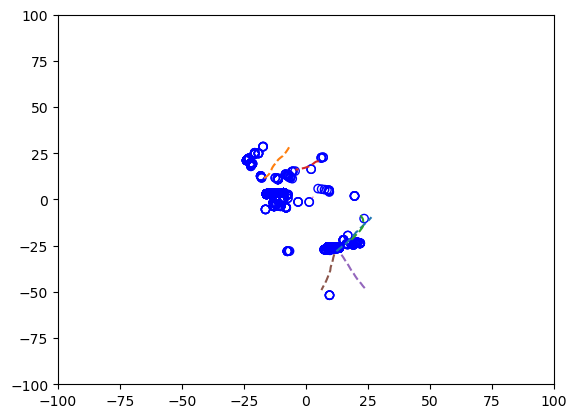

In [14]:
pos = np.array([s[:2] for s in history[-1]])
plt.scatter(*pos[:,:2].T, facecolors='none', edgecolors='blue')
plt.xlim(*area)
plt.ylim(*area)

for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])

for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    plt.plot(*pos[:,:2].T, linestyle='dashed')